### This notebook preprocesses text from a twitter airline sentiment [dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment),<br> in preparation for generating embeddings with a sentence transformer model.


In [130]:
import sys

sys.path.append("../")
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
import preprocessing.preprocessing as pp

In [131]:
# Run these two lines to have all plots appear on GitHub:
import plotly.io as pio

pio.renderers.default = "png"

Reading in the raw data:

In [132]:
df = pd.read_csv("../data/raw/twitter_airline_sentiment.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [133]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [134]:
df.tail()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


Print number of tweets and number of unique tweets:

In [135]:
print("Number of tweets: ", len(df["text"]))
print("Unique tweets: ", len(set(df["text"])))

Number of tweets:  14640
Unique tweets:  14427


Drop duplicates:

In [136]:
df["original_index"] = df.index
df_nd = df.drop_duplicates(subset=["text"], keep="last", ignore_index=True).copy()
print(len(df_nd))

14427


What do the retweets look like? <br>
Should they be kept?

In [137]:
retweets = [tweet for tweet in df_nd["text"] if "RT" in tweet]
print("Number of retweets in data set: ", len(retweets))
retweets[:10]

Number of retweets in data set:  117


['Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP',
 "@VirginAmerica You'd think paying an extra $100 bucks RT for luggage might afford you hiring an extra hand at @sfo #lame",
 "Always have it together!!! You're welcome! RT @VirginAmerica: @jessicajaymes You're so welcome.",
 '😎 RT @VirginAmerica: You’ve met your match. Got status on another airline? Upgrade (+restr): http://t.co/RHKaMx9VF5. http://t.co/PYalebgkJt',
 'Awesome! RT @VirginAmerica: Watch nominated films at 35,000 feet. #MeetTheFleet #Oscars http://t.co/DnStITRzWy',
 "@VirginAmerica If you'd love to see more girls be inspired to become pilots, RT our free WOAW event March 2-8 at ABQ. http://t.co/rfXlV1kGDh",
 'Nice RT @VirginAmerica: The man of steel might be faster, but we have WiFi – just saying. #ScienceBehindTheExperience http://t.co/FGRbpAZSiX',
 '@united Pls Help Baby Hannah get the life saving surgeries she requires.She nee

Print a random sample of tweets:

In [138]:
[print(tweet) for tweet in df_nd["text"].sample(15, random_state=11)];

@united great to hear Thankyou so much. Greatly appreciate your replies. Feel much more settled now.
@united Tell me that you're at least going to cover a room and get me out of here.
@JetBlue I'm over that honestly just would like to get going on the journey.
@USAirways would like to see you do similar in PHL! http://t.co/n9vGe2nPIB
@SouthwestAir if you are giving tix to #DestinationDragons show would appreciate one or two for LA😄Flying from PHL to LAX on Friday
@AmericanAir still waiting on a dm response..... #sloooowresponses
@JetBlue is the trueblue site broken at the moment?
@AmericanAir That's good, I'd expect that but I can't get through on the phone to make any changes. Can I change it online?
@SouthwestAir worst air line ever, you have no compassion of the handicapped
@JetBlue I just wanted to say flight attendant fitz was the best tonight on flight #1326 bwi/Bos. Great guy and made the flight fantastic!
@united no- we are boarding- but why can't your agents, on the phone, tak

### Process tweets through selected preprocessing steps:

In [139]:
df_nd["clean_text"] = df_nd["text"]
df_nd = (
    df_nd.pipe(pp.remove_emoji, col="clean_text", replace=True)
    .pipe(pp.remove_urls, col="clean_text")
    .pipe(pp.remove_html, col="clean_text")
    .pipe(
        pp.remove_symbols,
        col="clean_text",
        symbols=["@", "#"],
        remove_keyword=[True, True],
    )
    .pipe(pp.replace_curly_quotes, col="clean_text")
    .pipe(pp.remove_whitespace_currency, col="clean_text")
    .pipe(pp.fix_whitespace, col="clean_text")
)

/Users/garethsmith/Development/twitter_american_airlines/notebooks/../preprocessing/preprocessing.py:195: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [140]:
# Shows a random subset of tweets before and after cleaning

ind = np.random.choice(len(df_nd), 10)

for t, c in zip(df_nd["text"].to_numpy()[ind], df_nd["clean_text"].to_numpy()[ind]):
    print(f"Original: {t}")
    print(f"Cleaned:  {c}")
    print()

Original: @SouthwestAir sucks. Passengers leaving the plane to make room luggage, checking luggage and getting back on. Delayed flights to same city.
Cleaned:  sucks. Passengers leaving the plane to make room luggage, checking luggage and getting back on. Delayed flights to same city.

Original: @USAirways yeah either by refunding my money or 2 free round trips to compensate for all the trouble we were put through.
Cleaned:  yeah either by refunding my money or 2 free round trips to compensate for all the trouble we were put through.

Original: @JetBlue If you "follow" me, I will be able to DM you.  Thanks.
Cleaned:  If you "follow" me, I will be able to DM you. Thanks.

Original: @USAirways delays due to refueling are out of your control? If that's true I never want to fly US Airways again
Cleaned:  delays due to refueling are out of your control? If that's true I never want to fly US Airways again

Original: @united 3 hours of sitting in the plane that hasn't left the Gate yet. 6 mor

### Using PySpellChecker, we'll find potentially incorrect spellings

In [141]:
df_nd = pp.find_incorrect_spellings(df=df_nd, col="clean_text", distance=1)

In [142]:
# What are the most common spellings we should check?
counter = Counter()
df_nd["check_spellings"].apply(lambda x: counter.update(x.keys()))
counter.most_common()[:50]

[('...', 629),
 ('flightled', 488),
 ('.. .', 270),
 ('w', 247),
 ('dm', 243),
 ('hrs', 218),
 ('flighted', 212),
 ('aa', 179),
 ('..', 173),
 ('jfk', 173),
 ('flightr', 160),
 ("you're", 159),
 (':)', 152),
 ('fleek', 148),
 ('flt', 141),
 ('rebooked', 134),
 ('dfw', 131),
 ('sfo', 102),
 ('thx', 102),
 ('phl', 100),
 ('s', 97),
 ('rt', 94),
 ('jetblue', 94),
 ('dca', 92),
 ('pm', 90),
 (':(', 86),
 ('clt', 77),
 ('bos', 76),
 ('ewr', 71),
 ('nyc', 67),
 ('bc', 67),
 ('hr', 66),
 ('b', 64),
 ('c', 61),
 ('pls', 60),
 ('thru', 55),
 ('phx', 55),
 ('. .', 54),
 ('fll', 51),
 ('cust', 51),
 ('reflight', 51),
 ('lga', 49),
 ('dc', 49),
 ('... .', 48),
 ('1/2', 47),
 ('sw', 46),
 ('usair', 45),
 ('iah', 44),
 ('swa', 43),
 ('flighting', 42)]

### The spellchecker corrections are no use for most of the above, so manual attention is required.
### Manual checking is a fairly large job, but I will cover a subset relating to the unusual versions of "flight" that appear.
### Let's look at the text of the most common of those: 

In [143]:
[(w, counter[w]) for w in counter if "flight" in w and counter[w] > 20]

[('flightled', 488),
 ('flighted', 212),
 ('flightlation', 34),
 ('flighting', 42),
 ('flightr', 160),
 ('flightd', 25),
 ('reflight', 51),
 ('flightlations', 40)]

### Looking at the first of these ("flightled"), they all involve "Cancelled Flightled", which should be corrected to "cancelled":

In [144]:
[print(tweet) for tweet in df_nd["clean_text"] if "flightled" in tweet.lower()];

I like the TV and interesting video. Just disappointed in Cancelled Flightled flight when other flights went out to jfk on Saturday.
is flight 882 Cancelled Flightled and what do I do if it is?
your assistance yesterday when u Cancelled Flightled our flight was to give us a hotel hotline Shame on you!
- Is Flight 713 from Love Field to SFO definitely Cancelled Flightled for Monday, February 23?
How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!
Flight from BOS > LAS tomorrow was Cancelled Flightled. No notification; wait times are 1+ hour. Will you rebook on another airline?
You have any flights flying into Boston tomorrow? I need to be home and you Cancelled Flightled my flight and didn't do anything
nervous about my flight from DC to LAX getting Cancelled Flightled tomorrow! Just sent you a DM to help me!
why Cancelled Flight flight VX413? One sec its delayed, on my to airport, the next its Cancelled Flightled? Gonna email or call me to resche

### So we should replace "Cancelled Flightled" with "cancelled" or "Cancelled" as appropriate:

### Now looking at "flighted":

In [145]:
[print(tweet) for tweet in df_nd["clean_text"] if "flighted" in tweet.lower()];

our flight into lga was Cancelled Flighted. We're stuck in Dallas. I called to reschedule, told I could get a flight for today...(1/2)
you stink. Flight Cancelled Flighted from PSP to JFK and no notification or ability to rebook. better
You guys charged me $100 to reschedule a flight that was then Cancelled Flighted and are now refusing to refund it. What's the deal?
Cancelled Flighted our flight, didn't rebook us on added flight, now have to drive from a Denver to KC... .thanks!
checking to see why flight 3466 (atl-ord) got Cancelled Flighted?
you Cancelled Flighted our flights for no reason & now we have been on the phone for AN HOUR on our vacation. Why?
Not appropriate to ask in public (hence the dm). each united employee, each a new answer. your process was such a hassle i Cancelled Flighted.
On a standby to Denver, which has been delayed, and a confirmed to Aspen, whose flights have been Cancelled Flighted all day. 0 confidence.
2 Cancelled Flighted flights Late Flightr, agent cl

### Similar story with the above: "Cancelled Flighted" -> "cancelled"

### Now looking at "flightlation":

In [146]:
[print(tweet) for tweet in df_nd["clean_text"] if "flightlation" in tweet.lower()];

Because we never rec'd Cancelled Flightlation notice we were left w no options to fly out of PS. Driving to LA for a red eye Mon w kids
my group got their Cancelled Flightlation fees waived but I can't because my ticket is booked for 2/18? Your reps were no help either enraged_face
received hotel but no food. Also email for 3750 miles. Last trip had 3 hr delay and 5000 miles - so less for Cancelled Flightlation?
UA3388 was Cancelled Flightled not delayed. Re-Flight Booking Problems still 90 miles from home. At least acknowledge the Cancelled Flightlation.
I was sincerely thanking the pilot of flight 4461 of braving the snow and getting me home amongst many other Cancelled Flightlations.
can we get an explanation on why UA978 from São Paulo to Houston has been delayed? Now we're hearing from crew about Cancelled Flightlations.
Missed KTM flight due to ur Cancelled Flightlation. Mike supervisor disgusting. Now day Late Flight. No apology or upgrade offer to LHR from ORD???
I believe. It 

### Correction: "Cancelled Flightlations" -> "cancellations" and "Cancelled Flightlation" -> "cancellation":

### Now looking at "flighting":

In [147]:
[print(tweet) for tweet in df_nd["clean_text"] if "flighting" in tweet.lower()];

While other airlines weren't Cancelled Flighting flights into BOS, and helping their customers get home, Virgin was saying Good luck!
the least you could do is offer me a ticket in coach instead of just Cancelled Flighting my reservation because of your glitch!!!
heard about the voucher/miles credit for Cancelled Flighting my international flight yesterday, but I didn't get an email.
Well, to the degree that he could... Just to know, after this experience I'm Cancelled Flighting my miles card. Thank god for
it's my 21st birthday and my sister is coming to celebrate but her flights keep Cancelled Flighting PLZ do all you can to get her here!!!!
I'm Cancelled Flighting my card and I will NEVER do business with you again. You clearly don't care about your customers.
are you telling me that you are now Cancelled Flighting my flight??
- watched the entire game on the Tarmac before Cancelled Flighting my flight because crew timed out, right before my 4hr flight....
thanks for not letting me 

### This time the correction appears to be "Cancelled Flighting" -> "cancelling":

### Now looking at "flightr":

In [148]:
[print(tweet) for tweet in df_nd["clean_text"] if "flightr" in tweet.lower()];

See? We were told repeatedly that the pilot was Late Flight and kept getting Late Flightr. After we boarded, there was a defibrillator issue.
7 WEEKS Late FlightR AND I STILL HAVE NOT RECEIVED MY MILES FROM THE MileagePlus Gift Card $150 STARBUCKS CARD I HANDED OVER!!!
3 days Late Flightr and my bag has not left IAD, United is not helping at all. Everyone tells me a different story
your customer service is terrible! Stood inline 3 hours no flights and 4 hours Late Flightr still no bag
already did that at the airport and 12 hrs Late Flightr its still not here! you guys are really killing me today. trying to stay positive..
2 Cancelled Flighted flights Late Flightr, agent claimed she put me on a new flight but then Cancelled Flighted it. Coworker got on flight- now delayed. Now?
Now arriving a day and a half Late Flightr than supposed to. Lesson of the day, don't believe verbal or written confirmations from United
WHERE IS MY RECEIPT! I upgraded return leg and 6 months Late Flightr still

### This time the correction appears to be "Late Flightr" -> "later":

### Now looking at "flightd":

In [149]:
[print(tweet) for tweet in df_nd["clean_text"] if "flightd" in tweet.lower()];

I asked a legitimate question about systemwide vs. localized problems, and got back an unreLate Flightd copy/paste. You can do better.
This is the 2nd time I was rebooked (w/delays), and for reasons unreLate Flightd to weather. How do I go about requesting a flight voucher?
Sorry, . I accidentally popuLate Flightd with you instead of. Can't wait 'til "U" are the only "U" in the sky.
Wasn't frustrating! Well, not in any way reLate Flightd to y'all, anyway. Impressed that I made it.
- flight 1114. Unfortunately this isn't an isoLate Flightd incident. I haven't waited less than 20min in years
why was Southwest only airline to Cancelled Flight all flights from Charleston? Was 7:50pm flight Cancelled Flightation really weather reLate Flightd?
Completely understand Act of God weather-reLate Flightd Cancelled Flightlation, but 4 days without reimbursement of any kind is
Superb choice - SWA. I am a raving fan. They even take stress out of weather-reLate Flightd glitches!
Thanks. So the delay w

### This time the corrections are mostly "reLate Flightd" -> "related" or "unreLate Flightd" -> "unrelated"

### Now looking at "reflight":

In [150]:
[print(tweet) for tweet in df_nd["clean_text"] if "reflight" in tweet.lower()];

FAIL You Cancelled Flightled our flight frm GJT and then used our reserv home to IAH (from SEA) for reFlight Booking Problems w/out OUR PERMISSION!!
Just sent thank u RT: Please DM your confirmation number if reFlight Booking Problems is needed. Thank you. ^EY
they're not, actually. gate agent was so rude. now standing in a line waiting for reFlight Booking Problems. missed the only flight to STI. awful.
Now about two dozen back in line to see a single CSR for reFlight Booking Problems final leg. (Kiosks on fritz.)
Wanted to compliment ur phone agent Jeanette for reFlight Booking Problems RDU to SEA thru SFO after connecting flight thru EWR was Cancelled Flightled.
pushing five hours and my time is worth nothing to you. reFlight Booking Problems not an option unfortunately.
did your super computer pile_of_poo ots pants? Lots of cranky people in line at CMH reFlight Booking Problems, delaying check-ins of on-time, direct flyers
it is too Late Flight for reFlight Booking Problems now - i

### This time the correction seems to be "reFlight Booking Problems" -> "rebooking":

### Let's construct a dataframe of the findings:

In [151]:
text_corrections = {
    "word": [
        "flightled",
        "flighted",
        "flightlations",
        "flightlation",
        "flighting",
        "flightr",
        "flightd",
        "flightd",
        "flightd",
        "flightd",
        "flightd",
        "reflight",
        "reflight",
    ],
    "str_to_replace": [
        "Cancelled Flightled",
        "Cancelled Flighted",
        "Cancelled Flightlations",
        "Cancelled Flightlation",
        "Cancelled Flighting",
        "Late Flightr",
        "unreLate Flightd",
        "correLate Flightd",
        "popuLate Flightd",
        "isoLate Flightd",
        "reLate Flightd",
        "reFlight Booking Problems",
        "ReFlight Booking Problems",
    ],
    "replacement": [
        "cancelled",
        "cancelled",
        "cancellations",
        "cancellation",
        "cancelling",
        "later",
        "unrelated",
        "correlated",
        "populated",
        "isolated",
        "related",
        "rebooking",
        "Rebooking",
    ],
}

df_corrections = pd.DataFrame(text_corrections)
df_corrections

,word,str_to_replace,replacement
0,flightled,Cancelled Flightled,cancelled
1,flighted,Cancelled Flighted,cancelled
2,flightlations,Cancelled Flightlations,cancellations
3,flightlation,Cancelled Flightlation,cancellation
4,flighting,Cancelled Flighting,cancelling
5,flightr,Late Flightr,later
6,flightd,unreLate Flightd,unrelated
7,flightd,correLate Flightd,correlated
8,flightd,popuLate Flightd,populated
9,flightd,isoLate Flightd,isolated


### Now I will replace the bad substrings with the identified replacements:

In [152]:
[pp.replace_substring(df=df_nd, 
                    col="clean_text",
                    str_to_replace=df_corrections["str_to_replace"].iloc[i],
                    replacement=df_corrections["replacement"].iloc[i])
                    for i in df_corrections.index];

### Checking for any remaining issues:

In [153]:
for word in df_corrections["word"].unique():
    print(f"Bad text: {word}. Remaining issues:")
    [print(tweet) for tweet in df_nd["clean_text"] if word in tweet.lower()]
    print()

Bad text: flightled. Remaining issues:
thanks for ruined my vacation for having poorly maintained aircrafts that can't fly safely out of STT. Flightledflight
Flightled.. .tried to get refund but on hold. Can I get it after my flight would have departed?
waiting for a flight to FL for 1/2 marathon tmrw 4 charity. U bumped us 2a later flight & then Cancelled FlightLED IT. How can you fix this?
cannot provide us alternative flight until 36 hours later ruining our trip! Flightled.
anxious to see how you all care for customers you've inconvenienced Flightledflight

Bad text: flighted. Remaining issues:
flighted delayed for hours. 10pm arrival to Vegas is now 4am. Did you seriously lose my luggage???
message me if you want to issue a refund so someone else can use my seats tomorrow AM Flighted
thanks for helping with Booking Problems Flightedflight Yvonne Anthony. You will help us get to Tel Aviv on time.
disappoints AGAIN! Flighted flights appointments refund is a lie
UR service is so shitt

#### There are a few which could be handled separately, but the number is tiny in comparison to before.

### It is apparent that completely cleaning and correcting the text is a large job, but the above addresses some of the most obviously strange faults in the tweet text. Further time spent would be advisable.

### Let's re-do the incorrect spellings check:

In [154]:
df_nd = pp.find_incorrect_spellings(df=df_nd, col="clean_text", distance=1)

In [155]:
counter = Counter()
df_nd["check_spellings"].apply(lambda x: counter.update(x.keys()))
counter.most_common()[:50]

[('...', 629),
 ('.. .', 270),
 ('w', 247),
 ('dm', 243),
 ('hrs', 218),
 ('aa', 179),
 ('..', 173),
 ('jfk', 173),
 ("you're", 159),
 (':)', 152),
 ('fleek', 148),
 ('flt', 141),
 ('rebooked', 134),
 ('dfw', 131),
 ('sfo', 102),
 ('thx', 102),
 ('phl', 100),
 ('s', 97),
 ('rt', 94),
 ('jetblue', 94),
 ('dca', 92),
 ('pm', 90),
 (':(', 86),
 ('clt', 77),
 ('bos', 76),
 ('ewr', 71),
 ('nyc', 67),
 ('bc', 67),
 ('hr', 66),
 ('b', 64),
 ('c', 61),
 ('pls', 60),
 ('thru', 55),
 ('phx', 55),
 ('. .', 54),
 ('fll', 51),
 ('cust', 51),
 ('lga', 49),
 ('dc', 49),
 ('rebooking', 49),
 ('... .', 48),
 ('1/2', 47),
 ('sw', 46),
 ('usair', 45),
 ('iah', 44),
 ('swa', 43),
 ('tv', 41),
 ('mco', 39),
 (';)', 39),
 ('bwi', 39)]

### How long are the tweets? Perhaps very short tweets are not of value?

In [156]:
df_nd["tweet_length"] = df_nd["clean_text"].map(lambda x: len(x))

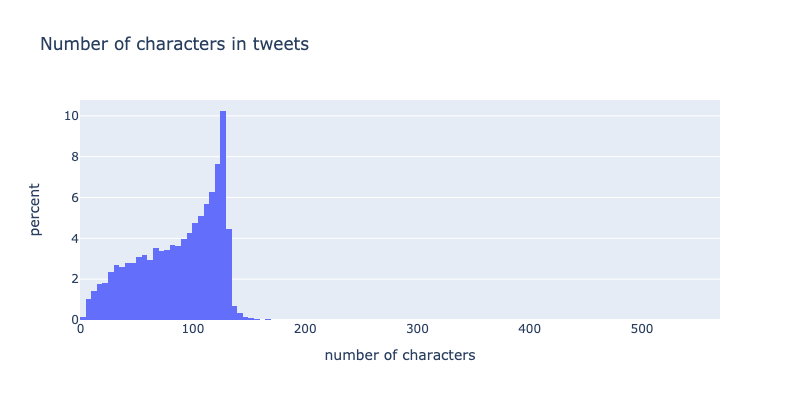

In [157]:
n_char_chart = px.histogram(
    df_nd,
    x="tweet_length",
    nbins=200,
    histnorm="percent",
    labels={"tweet_length": "number of characters"},
    title="Number of characters in tweets",
    width=800,
    height=400,
)
n_char_chart.show()

Very short tweets are nearly all brief replies, e.g. 'thank you' to operators, but mostly contain too little content to be informative individually. Hence I will remove those of three words or less.

In [158]:
# Look at tweets with 3 words or less
short_tweets = df_nd["clean_text"][df_nd["clean_text"].str.count(" ").lt(3)]
[print(tweet) for tweet in short_tweets.sample(15, random_state=11)];

awesome! Thx
Thanks a ton!
snapchat, iMessage, instagram......
thank you!!
I will. Thanks.
thank you
done thnx
flight number
never again.
Apparently not.
Worst airline ever?
yes, with Delta!
Great, thanks. Followed.
please please please
pathetic service


In [159]:
# Drop tweets with 3 words or less
df_nd = df_nd[df_nd["clean_text"].str.count(" ").gt(2)].reset_index(drop=True)
print(df_nd.shape)

(13854, 19)


In [160]:
save_str = "_emoji_urls_html_symbols@#_quotes_currency_whitespace_3wordtweetdrop_flightspellcorrect"

In [161]:
# df_nd.to_csv(
#    f"../data/processed/twitter_airline_sentiment_cleaned{save_str}.csv", index=False
# )